In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [6]:
def preprocess_image(features):
    """Preprocesses the given image.
       will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
       mean = [103.939, 116.779, 123.68]
       std = None
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    features["image"] = image
    return features

# Load Data

In [7]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/') # use the last 20% of images among 50000 validation images for testing
#tf.compat.v1.data.make_one_shot_iterator(tfds_dataset1).get_next()

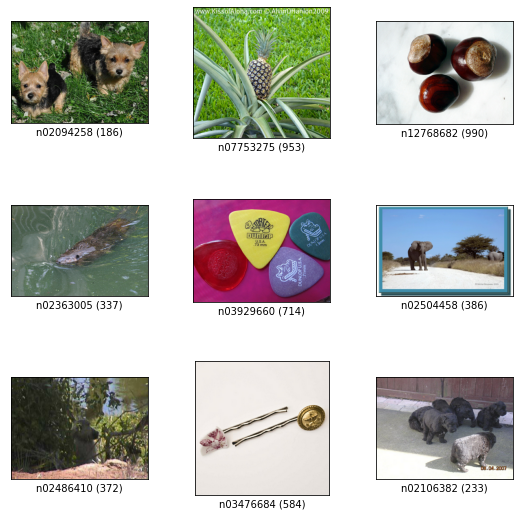

In [8]:
figs = tfds.show_examples(tfds_dataset2, tfds_info)

In [9]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

# Load Model

In [10]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = ResNet50(input_shape=input_shape)

In [11]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [12]:
model = ResNet50(input_tensor = q_model.input)

In [13]:
model.load_weights("./original_model_40.h5")
q_model.load_weights("./int8_model_40.h5")

# Display Image

In [14]:
def extract(ith_image):
    for i, features in enumerate(val_ds):
        if ith_image < 50 and i == 0:
            image = np.expand_dims(features["image"].numpy()[ith_image], axis=0)
            label = features["label"].numpy()[ith_image]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
        
        elif i == np.floor(ith_image/50):
            image = np.expand_dims(features["image"].numpy()[ith_image%50], axis=0)
            label = features["label"].numpy()[ith_image%50]
            logits_1 = model(image)
            logits_2 = q_model(image)
            predict_1 = tf.argmax(logits_1, axis=-1).numpy()[0]
            predict_2 = tf.argmax(logits_2, axis=-1).numpy()[0]
            break
    return image, label,logits_1,logits_2,predict_1,predict_2

In [15]:
image,label,logits_1,logits_2,predict_1,predict_2 = extract(1)

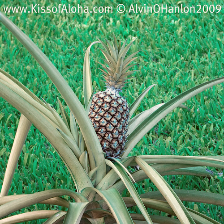

In [16]:
pil_img = tf.keras.preprocessing.image.array_to_img(image[0,:,:,:])
from IPython.display import Image
display(pil_img)

In [17]:
tf.keras.applications.resnet.decode_predictions(logits_1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.99969995),
 ('n07730033', 'cardoon', 0.00012114261),
 ('n04311004', 'steel_arch_bridge', 2.4950892e-05),
 ('n03991062', 'pot', 2.1275095e-05),
 ('n03457902', 'greenhouse', 2.0334784e-05)]

In [18]:
tf.keras.applications.resnet.decode_predictions(logits_2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9844577),
 ('n03457902', 'greenhouse', 0.0024166899),
 ('n04311004', 'steel_arch_bridge', 0.0021014735),
 ('n07730033', 'cardoon', 0.0018273707),
 ('n04523525', 'vault', 0.0009742933)]

In [19]:
#np.save("./trailer_truck.npy",image)

# Baseline: PGD

$ A = argmax_A \,\, [ \,\, L( \,\, model_{quant} \,\, (image + A) , y )\,\, ]$

In [20]:
grad_iterations = 100
step = 0.01
epsilon = 8
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0
loss = tf.keras.losses.SparseCategoricalCrossentropy()
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        predict = q_model(input_image + A)
        final_loss = loss(orig_label , predict)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
    print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Oh no!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

[('n02607072', 'anemone_fish', 0.92407775), ('n01914609', 'sea_anemone', 0.07581025), ('n09256479', 'coral_reef', 4.5047418e-05), ('n02317335', 'starfish', 2.1885102e-05), ('n01910747', 'jellyfish', 2.0950774e-05)]
[('n02607072', 'anemone_fish', 0.92604333), ('n01914609', 'sea_anemone', 0.06067887), ('n02317335', 'starfish', 0.00171894), ('n01910747', 'jellyfish', 0.0016029214), ('n04209239', 'shower_curtain', 0.0009828162)]
[('n02607072', 'anemone_fish', 0.9185031), ('n01914609', 'sea_anemone', 0.08137901), ('n09256479', 'coral_reef', 4.6672416e-05), ('n01910747', 'jellyfish', 2.299731e-05), ('n02317335', 'starfish', 2.2967328e-05)]
[('n02607072', 'anemone_fish', 0.9209283), ('n01914609', 'sea_anemone', 0.064711325), ('n02317335', 'starfish', 0.0018331741), ('n01910747', 'jellyfish', 0.0017094454), ('n04209239', 'shower_curtain', 0.0011239935)]
[('n02607072', 'anemone_fish', 0.91268915), ('n01914609', 'sea_anemone', 0.08718459), ('n09256479', 'coral_reef', 4.9095124e-05), ('n01910747'

[('n02607072', 'anemone_fish', 0.734494), ('n01914609', 'sea_anemone', 0.26516503), ('n01910747', 'jellyfish', 0.00011271453), ('n09256479', 'coral_reef', 9.339846e-05), ('n02317335', 'starfish', 5.7573507e-05)]
[('n02607072', 'anemone_fish', 0.75283533), ('n01914609', 'sea_anemone', 0.19956182), ('n01910747', 'jellyfish', 0.006501266), ('n02317335', 'starfish', 0.0060624676), ('n04209239', 'shower_curtain', 0.0042747087)]
[('n02607072', 'anemone_fish', 0.71969485), ('n01914609', 'sea_anemone', 0.27994642), ('n01910747', 'jellyfish', 0.000121386955), ('n09256479', 'coral_reef', 9.591625e-05), ('n02317335', 'starfish', 5.967151e-05)]
[('n02607072', 'anemone_fish', 0.7528031), ('n01914609', 'sea_anemone', 0.19955327), ('n02317335', 'starfish', 0.006500987), ('n01910747', 'jellyfish', 0.0060622073), ('n04209239', 'shower_curtain', 0.004274525)]
[('n02607072', 'anemone_fish', 0.70513874), ('n01914609', 'sea_anemone', 0.29448706), ('n01910747', 'jellyfish', 0.00012922322), ('n09256479', 'co

KeyboardInterrupt: 

In [20]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9800582),
 ('n04311004', 'steel_arch_bridge', 0.0061194194),
 ('n07730033', 'cardoon', 0.0018775858),
 ('n03065424', 'coil', 0.0016161946),
 ('n03891251', 'park_bench', 0.0015353849)]

In [21]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.2873711),
 ('n04311004', 'steel_arch_bridge', 0.2873711),
 ('n03457902', 'greenhouse', 0.046706844),
 ('n04523525', 'vault', 0.032933485),
 ('n03891251', 'park_bench', 0.018829953)]

# Generate adverserial example

## 1. A = argmax c*L( q_model(image + A) , sudo_y) -  L( orig_model(image + A) , y) 

In [19]:
#image = np.load("./trailer_truck.npy")

In [80]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [81]:
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [82]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.MSE(model(input_image + A)[0] , q_model(input_image + A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.MSE(orig_logist[0] , model(input_image + A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
Success!


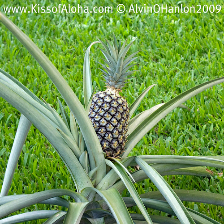

In [83]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [84]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.8396676),
 ('n04311004', 'steel_arch_bridge', 0.10018927),
 ('n03891251', 'park_bench', 0.007436854),
 ('n03065424', 'coil', 0.007423674),
 ('n07730033', 'cardoon', 0.0045490763)]

In [85]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n04311004', 'steel_arch_bridge', 0.7117477),
 ('n03891251', 'park_bench', 0.017532844),
 ('n03457902', 'greenhouse', 0.017532844),
 ('n04523525', 'vault', 0.016349478),
 ('n07753275', 'pineapple', 0.012362596)]

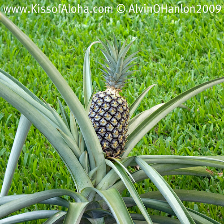

In [26]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

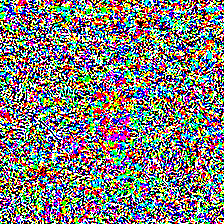

In [27]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed - orig_img_deprocessed)

# Transferability

In [87]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model__ = ResNet50(input_shape=input_shape)
t_q_model = tfmot.quantization.keras.quantize_model(model__)
t_model = ResNet50(input_tensor = q_model.input)
t_model.load_weights("./transferability_original_model_40.h5")
t_q_model.load_weights("./transferability_q_model_40.h5")

In [88]:
input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(t_model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [89]:
pred1, pred2= t_model(input_image), t_q_model(input_image)

In [90]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.9998584),
 ('n07730033', 'cardoon', 8.528743e-05),
 ('n03991062', 'pot', 9.311455e-06),
 ('n03457902', 'greenhouse', 7.3394053e-06),
 ('n11939491', 'daisy', 5.935758e-06)]

In [91]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.985115),
 ('n03457902', 'greenhouse', 0.0022353348),
 ('n07730033', 'cardoon', 0.0020734745),
 ('n04311004', 'steel_arch_bridge', 0.0013207971),
 ('n04523525', 'vault', 0.0006228716)]

In [92]:
c = 1e2
grad_iterations = 20
step = 1
epsilon = 8

In [93]:
for iters in range(0,grad_iterations):
    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.MSE(t_model(input_image + A)[0] , t_q_model(input_image + A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.MSE(orig_logist[0] , t_model(input_image + A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        #print(final_loss)


        grads = normalize(g.gradient(final_loss, input_image))
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= t_model(test_image), t_q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    pred3, pred4= model(test_image), q_model(test_image)
    label3, label4 = np.argmax(pred3[0]), np.argmax(pred4[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6\
            and tf.keras.applications.resnet.decode_predictions(pred4.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
different
different
different
different
different
different
different
different
Success!


In [94]:
pred1, pred2= model(test_image), q_model(test_image)

In [95]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n07753275', 'pineapple', 0.761649),
 ('n02096177', 'cairn', 0.0683009),
 ('n03065424', 'coil', 0.028439429),
 ('n03891251', 'park_bench', 0.024870502),
 ('n04501370', 'turnstile', 0.011246435)]

In [96]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n02096177', 'cairn', 0.79203093),
 ('n02097298', 'Scotch_terrier', 0.029672889),
 ('n02113712', 'miniature_poodle', 0.009700247),
 ('n02093754', 'Border_terrier', 0.009045536),
 ('n02097209', 'standard_schnauzer', 0.008435014)]

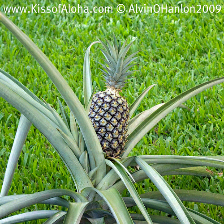

In [97]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

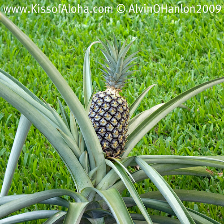

In [98]:
tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed)

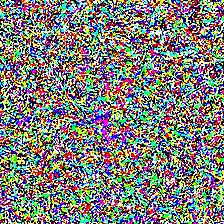

In [99]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed - orig_img_deprocessed)

## 2. A = argmax orig_model(image + A)[y] - c*q_model(image + A)[y]

In [85]:
image = np.load("./trailer_truck.npy")

In [62]:
c = 1
grad_iterations = 20
step = 1
epsilon = 8

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_logist = tf.identity(model(image))
orig_label =  np.argmax(orig_logist[0])
A = 0

In [63]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = K.mean(model(input_image+A)[..., orig_label])
        loss2 = K.mean(q_model(input_image+A)[..., orig_label])
        final_loss = K.mean(loss1 - c*loss2)

        grads = normalize(g.gradient(final_loss, input_image))

        # input_image += grads * step    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        if label1 == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

different
Success!


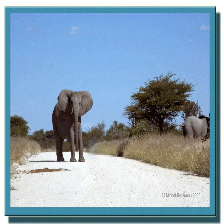

In [64]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [65]:
tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0]

[('n02504458', 'African_elephant', 0.93234205),
 ('n01871265', 'tusker', 0.03498963),
 ('n02437312', 'Arabian_camel', 0.01046668),
 ('n02504013', 'Indian_elephant', 0.0093830675),
 ('n02415577', 'bighorn', 0.0062462576)]

In [66]:
tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0]

[('n02437312', 'Arabian_camel', 0.2506604),
 ('n02504458', 'African_elephant', 0.0819424),
 ('n02415577', 'bighorn', 0.07641175),
 ('n09421951', 'sandbar', 0.03542631),
 ('n06359193', 'web_site', 0.03542631)]

In [92]:
print(A)

tf.Tensor(
[[[[ 1.  1.  1.]
   [ 1.  1. -1.]
   [-1.  1. -1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[ 1.  1. -1.]
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   ...
   [-1. -1. -1.]
   [ 1. -1.  1.]
   [-1. -1. -1.]]

  [[ 1.  1.  1.]
   [ 1.  1.  1.]
   [ 1.  1.  1.]
   ...
   [-1. -1. -1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  ...

  [[-1. -1.  1.]
   [-1. -1.  1.]
   [-1.  1.  1.]
   ...
   [ 1.  1.  1.]
   [-1. -1. -1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [ 1. -1. -1.]
   [ 1. -1.  1.]
   ...
   [ 1.  1.  1.]
   [-1.  1.  1.]
   [-1. -1. -1.]]

  [[-1. -1. -1.]
   [-1. -1. -1.]
   [ 1. -1.  1.]
   ...
   [ 1.  1.  1.]
   [-1. -1. -1.]
   [ 1.  1.  1.]]]], shape=(1, 224, 224, 3), dtype=float32)


# 3. Cross Entropy Loss

In [93]:
image = np.load("./trailer_truck.npy")

In [94]:
c = 1
grad_iterations = 100
transformation = 'light'
step = 1

input_image = tf.convert_to_tensor(image)
orig_img = tf.identity(input_image)
orig_label =  np.argmax(orig_logist[0])
A = 0
epsilon = 8

In [95]:
for iters in range(grad_iterations):

    with tf.GradientTape() as g:
        g.watch(input_image)
        loss1 = tf.keras.losses.categorical_crossentropy(model(input_image+A)[0] , q_model(input_image+A)[0])
        # increases this loss, c should be large to make this more importatnt
        loss2 = tf.keras.losses.categorical_crossentropy(orig_logist[0] , model(input_image+A)[0])
        # decreases this loss
        final_loss = loss1 - c*loss2
        print(final_loss)

    grads = normalize(g.gradient(final_loss, input_image))
    
    A += tf.sign(grads) * step
    A = tf.clip_by_value(A, -epsilon, epsilon)
    test_image_deprocess = deprocess_image((input_image + A).numpy())
    test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(test_image_deprocess), axis=0)
    pred1, pred2= model(test_image), q_model(test_image)
    label_ = np.argmax(pred1[0])
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        print("different")
        print(label1)
        print(label2)
        print(tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0])
        print(tf.keras.applications.resnet.decode_predictions(pred2.numpy(), top=5)[0])
        if label_ == orig_label and tf.keras.applications.resnet.decode_predictions(pred1.numpy(), top=5)[0][0][2] > 0.6:
            print("Success!")
            gen_img_deprocessed = test_image_deprocess
            orig_img_deprocessed = deprocess_image(orig_img.numpy())
            break

tf.Tensor(0.3754797, shape=(), dtype=float32)
different
779
565
[('n04146614', 'school_bus', 0.75182736), ('n03272562', 'electric_locomotive', 0.12491274), ('n03769881', 'minibus', 0.05344212), ('n03895866', 'passenger_car', 0.040773574), ('n04335435', 'streetcar', 0.009641159)]
[('n03393912', 'freight_car', 0.5083945), ('n03272562', 'electric_locomotive', 0.21979518), ('n03769881', 'minibus', 0.07185236), ('n03895866', 'passenger_car', 0.06700275), ('n04310018', 'steam_locomotive', 0.033312485)]
tf.Tensor(-4.2410603, shape=(), dtype=float32)
tf.Tensor(-2.9253335, shape=(), dtype=float32)
tf.Tensor(-1.4447447, shape=(), dtype=float32)
tf.Tensor(0.47527504, shape=(), dtype=float32)
different
41
525
[('n01685808', 'whiptail', 0.18073148), ('n01695060', 'Komodo_dragon', 0.08943513), ('n01689811', 'alligator_lizard', 0.071047254), ('n01675722', 'banded_gecko', 0.05828792), ('n01697457', 'African_crocodile', 0.05704562)]
[('n03160309', 'dam', 0.047729567), ('n04486054', 'triumphal_arch', 0.

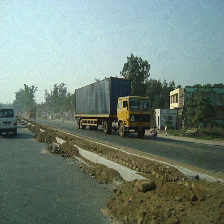

In [96]:
tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed)

In [97]:
print(A)

tf.Tensor(
[[[[-4. -2. -2.]
   [-2.  0.  0.]
   [ 0. -2. -7.]
   ...
   [-6. -6. -2.]
   [ 0.  0. -2.]
   [ 2.  2.  2.]]

  [[-2.  0.  2.]
   [-2. -2. -4.]
   [ 0.  4. -2.]
   ...
   [ 2.  2.  0.]
   [ 2.  2.  6.]
   [-2. -2. -4.]]

  [[ 4.  0.  0.]
   [ 0.  2.  2.]
   [ 4.  6.  8.]
   ...
   [ 0.  2.  6.]
   [-2.  2. -2.]
   [-4. -2. -2.]]

  ...

  [[ 0.  0.  0.]
   [ 2. -2. -2.]
   [ 2.  4.  4.]
   ...
   [ 2.  2.  0.]
   [ 2.  4. -4.]
   [ 2.  0. -2.]]

  [[ 0. -4.  4.]
   [ 0. -2.  0.]
   [ 4. -2.  0.]
   ...
   [ 6.  4.  2.]
   [ 2.  2.  6.]
   [ 2. -2.  2.]]

  [[ 0.  0.  2.]
   [ 2.  0.  4.]
   [-2. -2.  2.]
   ...
   [ 0.  0. -2.]
   [ 0.  2.  4.]
   [ 0. -4.  2.]]]], shape=(1, 224, 224, 3), dtype=float32)


In [98]:
test_image = np.expand_dims(tf.keras.applications.resnet.preprocess_input(gen_img_deprocessed), axis=0)
pred1, pred2= model(test_image), q_model(test_image)
label_ = np.argmax(pred1[0])
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

In [99]:
label1, label2

(867, 170)